In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

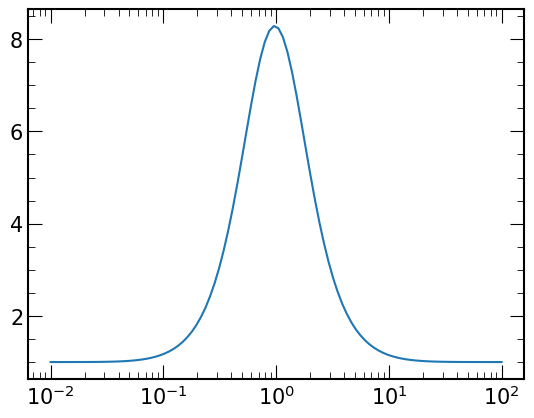

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-f16f6e87851c>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
8.057328224182129
2 0.1
finished until t = 0.0 0.9369978904724121


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.570822477340698
finished until t = 1.0 12.669461011886597
finished until t = 1.5 21.671274662017822
finished until t = 2.0 32.343363761901855
finished until t = 2.5 44.39426851272583
finished until t = 3.0 57.7968168258667
finished until t = 3.5 72.3560061454773
finished until t = 4.0 88.3000283241272
finished until t = 4.5 105.46780228614807
finished until t = 5.0 123.08209156990051
finished until t = 5.5 141.9281988143921
finished until t = 6.0 161.66054272651672
finished until t = 6.5 182.7671344280243
finished until t = 7.0 204.77473068237305
finished until t = 7.5 227.40288877487183
finished until t = 8.0 251.33737421035767
finished until t = 8.5 276.52596282958984
finished until t = 9.0 302.1370940208435
finished until t = 9.5 329.6481943130493
finished until t = 10.0 357.94139099121094


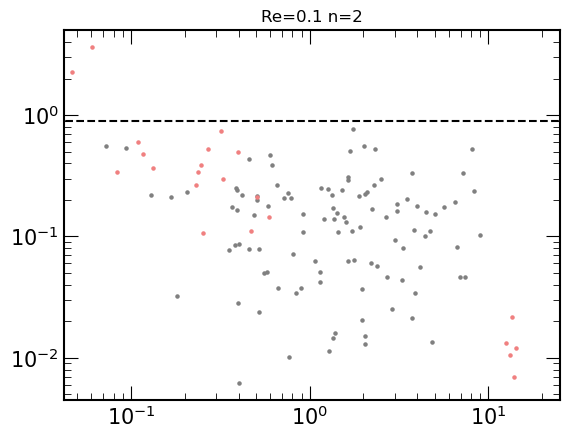

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.21673059463501
2 0.6
finished until t = 0.0 0.4808211326599121
finished until t = 0.5 4.168111085891724
finished until t = 1.0 11.289957046508789
finished until t = 1.5 22.12635087966919
finished until t = 2.0 36.4170560836792
finished until t = 2.5 54.43022966384888
finished until t = 3.0 75.95091581344604
finished until t = 3.5 101.40621900558472
finished until t = 4.0 130.2012975215912
finished until t = 4.5 162.10147380828857
finished until t = 5.0 197.7571005821228
finished until t = 5.5 236.71317505836487
finished until t = 6.0 278.5994505882263
finished until t = 6.5 324.8611464500427
finished until t = 7.0 375.783433675766
finished until t = 7.5 431.1686155796051
finished until t = 8.0 491.5094015598297
finished until t = 8.5 561.8189947605133
finished until t = 9.0 639.0770297050476
finished until t = 9.5 725.865612745285
finished until t = 10.0 817.0624933242798


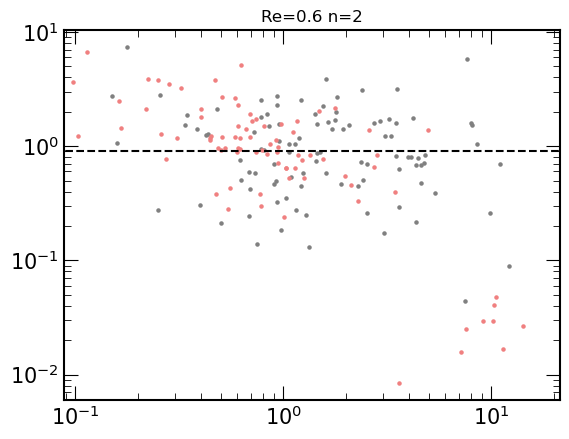

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.729762554168701
2 1.1
finished until t = 0.0 0.660846471786499
finished until t = 0.5 5.699235677719116
finished until t = 1.0 15.227278709411621
finished until t = 1.5 29.409191608428955
finished until t = 2.0 48.127089500427246
finished until t = 2.5 71.61241722106934
finished until t = 3.0 100.4217255115509
finished until t = 3.5 136.44947457313538
finished until t = 4.0 177.53289484977722
finished until t = 4.5 224.04592990875244
finished until t = 5.0 275.54973435401917
finished until t = 5.5 332.538122177124
finished until t = 6.0 394.14661383628845
finished until t = 6.5 461.4077959060669
finished until t = 7.0 543.0347151756287
finished until t = 7.5 637.2196977138519
finished until t = 8.0 737.5124440193176
finished until t = 8.5 844.0323579311371
finished until t = 9.0 956.950258731842
finished until t = 9.5 1075.001431941986
finished until t = 10.0 1200.2544441223145


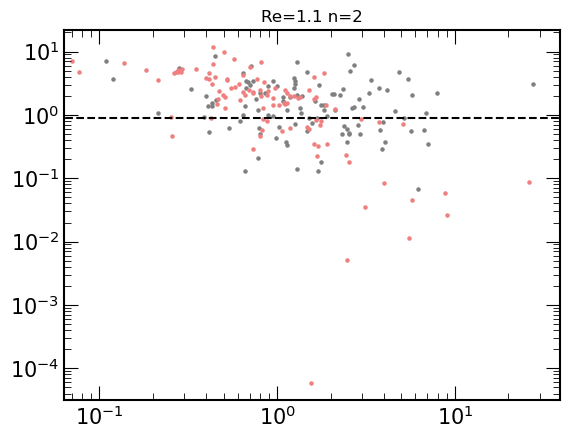

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.067337036132812
2 1.6
finished until t = 0.0 0.7932469844818115
finished until t = 0.5 5.888924598693848
finished until t = 1.0 15.395272254943848
finished until t = 1.5 29.18350338935852
finished until t = 2.0 47.50919246673584
finished until t = 2.5 70.98303151130676
finished until t = 3.0 99.11468410491943
finished until t = 3.5 132.5083246231079
finished until t = 4.0 170.79096961021423
finished until t = 4.5 213.62872576713562
finished until t = 5.0 262.08970737457275
finished until t = 5.5 315.41366696357727
finished until t = 6.0 374.2835373878479
finished until t = 6.5 438.5408399105072
finished until t = 7.0 507.0997188091278
finished until t = 7.5 580.8920402526855
finished until t = 8.0 659.7061564922333
finished until t = 8.5 743.5208010673523
finished until t = 9.0 832.3196651935577
finished until t = 9.5 924.9011287689209
finished until t = 10.0 1023.0293362140656


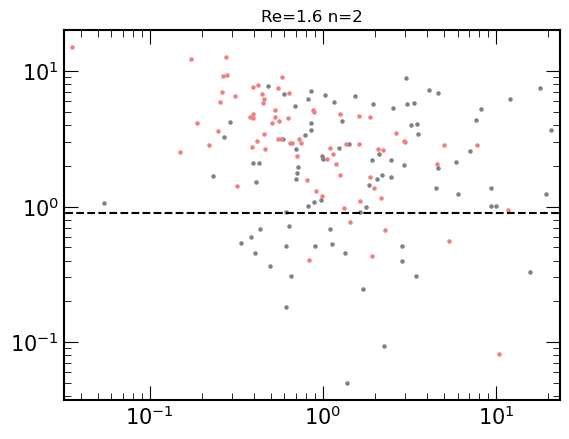

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.98728060722351
2 2.1
finished until t = 0.0 0.7935137748718262
finished until t = 0.5 6.308436155319214
finished until t = 1.0 15.817955255508423
finished until t = 1.5 29.80697798728943
finished until t = 2.0 48.66460394859314
finished until t = 2.5 72.17956280708313
finished until t = 3.0 100.38169169425964
finished until t = 3.5 133.06708931922913
finished until t = 4.0 170.80458092689514
finished until t = 4.5 212.19372582435608
finished until t = 5.0 258.6021423339844
finished until t = 5.5 309.2901005744934
finished until t = 6.0 364.47722458839417
finished until t = 6.5 423.91050124168396
finished until t = 7.0 488.4030339717865
finished until t = 7.5 556.4146866798401
finished until t = 8.0 629.7677507400513
finished until t = 8.5 707.6839184761047
finished until t = 9.0 789.9734663963318
finished until t = 9.5 876.9110798835754
finished until t = 10.0 968.458829164505


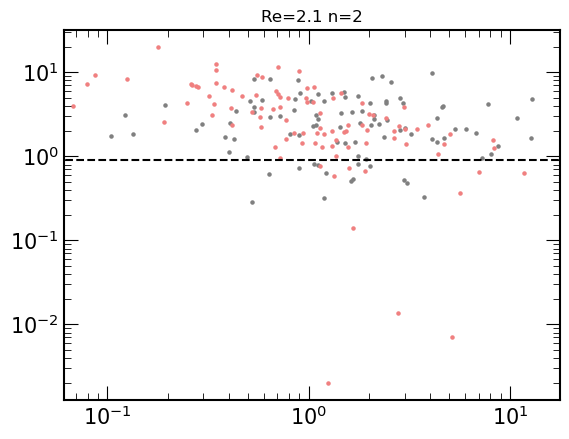

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.759247779846191
2 2.6
finished until t = 0.0 0.8293185234069824
finished until t = 0.5 5.842318296432495
finished until t = 1.0 14.914929628372192
finished until t = 1.5 28.39886975288391
finished until t = 2.0 46.041263818740845
finished until t = 2.5 67.99589037895203
finished until t = 3.0 94.39217019081116
finished until t = 3.5 125.23160004615784
finished until t = 4.0 161.00843000411987
finished until t = 4.5 200.5861120223999
finished until t = 5.0 245.20075964927673
finished until t = 5.5 294.4479012489319
finished until t = 6.0 347.7465240955353
finished until t = 6.5 406.2099940776825
finished until t = 7.0 469.70606994628906
finished until t = 7.5 537.2993590831757
finished until t = 8.0 610.1996095180511
finished until t = 8.5 688.1059441566467
finished until t = 9.0 770.2970488071442
finished until t = 9.5 858.1914103031158
finished until t = 10.0 949.730884552002


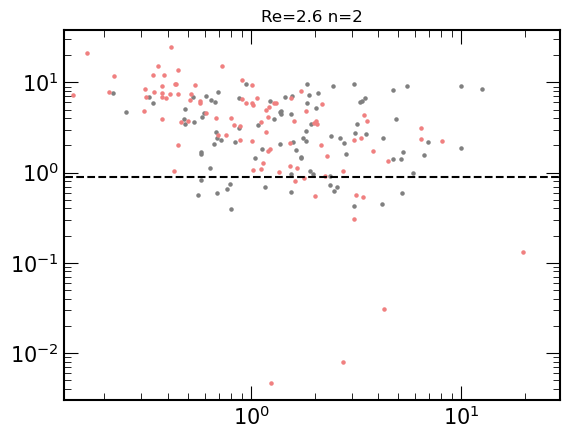

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
13.86921763420105
2 3.1
finished until t = 0.0 0.8860983848571777
finished until t = 0.5 6.31830620765686
finished until t = 1.0 15.837595224380493
finished until t = 1.5 30.31545925140381
finished until t = 2.0 49.2930223941803
finished until t = 2.5 72.28830862045288
finished until t = 3.0 99.61867141723633
finished until t = 3.5 132.01317715644836
finished until t = 4.0 168.5829668045044
finished until t = 4.5 210.02139019966125
finished until t = 5.0 255.91330933570862
finished until t = 5.5 306.2243344783783
finished until t = 6.0 361.5254237651825
finished until t = 6.5 421.5366780757904
finished until t = 7.0 486.4833860397339
finished until t = 7.5 556.0271844863892
finished until t = 8.0 630.4250223636627
finished until t = 8.5 709.1042733192444
finished until t = 9.0 792.1828062534332
finished until t = 9.5 879.7956795692444
finished until t = 10.0 971.7028985023499


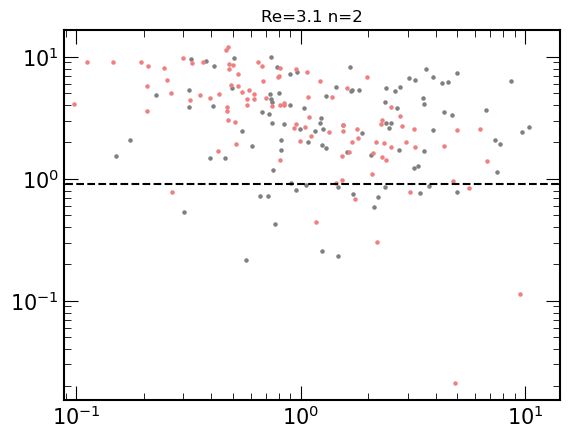

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
14.1201171875
2 3.6
finished until t = 0.0 0.9037272930145264
finished until t = 0.5 6.399954080581665
finished until t = 1.0 17.388256788253784
finished until t = 1.5 33.02467894554138
finished until t = 2.0 54.06522274017334
finished until t = 2.5 79.67299675941467
finished until t = 3.0 110.27591919898987
finished until t = 3.5 146.00759720802307
finished until t = 4.0 186.6820206642151
finished until t = 4.5 232.28941106796265
finished until t = 5.0 282.7598469257355
finished until t = 5.5 338.1865541934967
finished until t = 6.0 398.70631551742554
finished until t = 6.5 464.3197720050812
finished until t = 7.0 534.4118423461914
finished until t = 7.5 609.3900663852692
finished until t = 8.0 689.5707015991211
finished until t = 8.5 767.2247285842896
finished until t = 9.0 849.4012024402618
finished until t = 9.5 935.9974701404572
finished until t = 10.0 1026.7698636054993


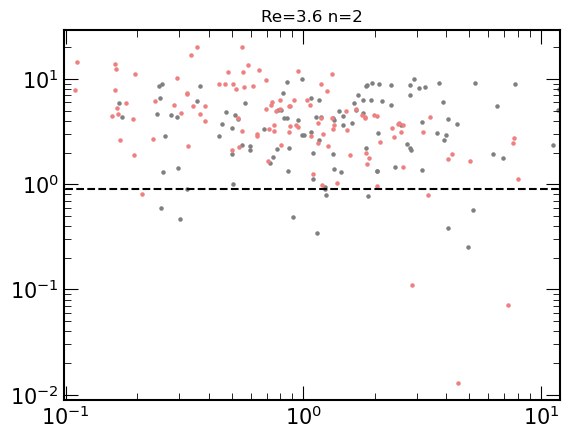

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.698122501373291
2 4.1
finished until t = 0.0 0.7539498805999756
finished until t = 0.5 5.379477024078369
finished until t = 1.0 13.961350679397583
finished until t = 1.5 26.813754320144653
finished until t = 2.0 43.66785168647766
finished until t = 2.5 64.50324702262878
finished until t = 3.0 89.67861771583557
finished until t = 3.5 119.19503140449524
finished until t = 4.0 153.07118034362793
finished until t = 4.5 190.41753554344177
finished until t = 5.0 232.2919158935547
finished until t = 5.5 278.0700726509094
finished until t = 6.0 327.8838720321655
finished until t = 6.5 382.6177501678467
finished until t = 7.0 441.4681248664856
finished until t = 7.5 504.76550340652466
finished until t = 8.0 571.8941974639893
finished until t = 8.5 638.1970646381378
finished until t = 9.0 706.3932530879974
finished until t = 9.5 778.8702545166016
finished until t = 10.0 854.6630144119263


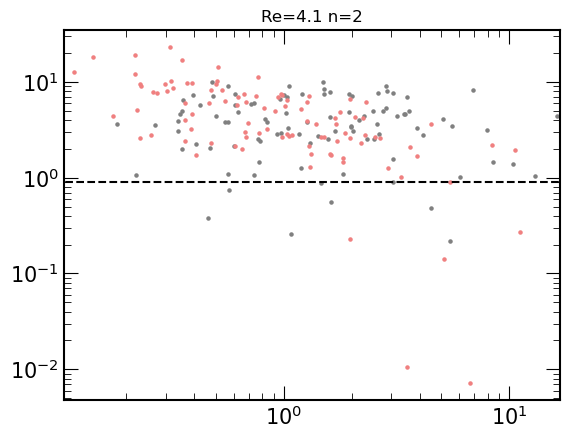

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.978344202041626
2 4.6
finished until t = 0.0 0.6988122463226318
finished until t = 0.5 4.679143667221069
finished until t = 1.0 12.08510160446167
finished until t = 1.5 22.917903661727905
finished until t = 2.0 37.490569829940796
finished until t = 2.5 55.38898324966431
finished until t = 3.0 76.42669415473938
finished until t = 3.5 101.0039598941803


In [ ]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [2]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [3]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.812458753585815
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
10.443303108215332


In [4]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [2]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [5]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 1.9332799911499023
finished until t = 0.5 68.13836526870728
finished until t = 1.0 199.67107725143433
finished until t = 1.5 465.75616002082825
finished until t = 2.0 861.8133940696716
finished until t = 2.5 1354.0034294128418
finished until t = 3.0 1929.746351480484
finished until t = 3.5 2598.65660905838
finished until t = 4.0 3361.7874467372894
finished until t = 4.5 4222.190545320511
finished until t = 5.0 5173.815531730652
finished until t = 5.5 6220.359870195389
finished until t = 6.0 7353.943544387817
finished until t = 6.5 8568.905494213104
finished until t = 7.0 9880.348809719086
finished until t = 7.5 11276.190651893616
finished until t = 8.0 12785.654136896133
finished until t = 8.5 14389.906565666199
finished until t = 9.0 16071.694464206696
finished until t = 9.5 17771.277081489563
finished until t = 10.0 19450.255345106125


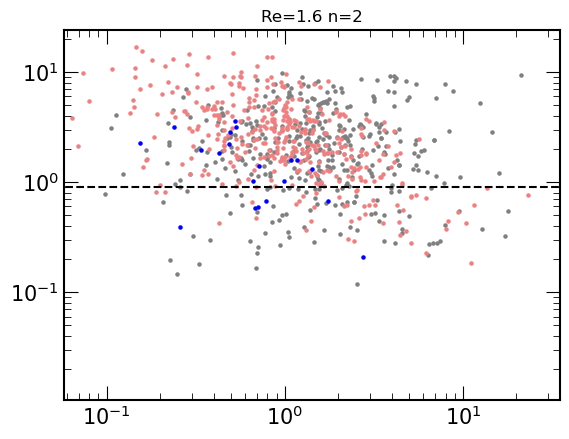

finished until t = 0.0 1.9131782054901123
finished until t = 0.5 89.38925886154175
finished until t = 1.0 261.18102979660034
finished until t = 1.5 517.478434085846
finished until t = 2.0 856.3142464160919
finished until t = 2.5 1278.5636451244354
finished until t = 3.0 1786.0841476917267
finished until t = 3.5 2376.370760202408
finished until t = 4.0 3048.8441438674927
finished until t = 4.5 3792.4154670238495
finished until t = 5.0 4615.764813184738
finished until t = 5.5 5530.493525981903
finished until t = 6.0 6529.851908922195
finished until t = 6.5 7599.200594902039
finished until t = 7.0 8741.45382142067
finished until t = 7.5 9962.748736858368
finished until t = 8.0 11263.271433591843
finished until t = 8.5 12612.347363710403
finished until t = 9.0 13745.00970339775
finished until t = 9.5 14883.640928030014
finished until t = 10.0 16038.464453220367


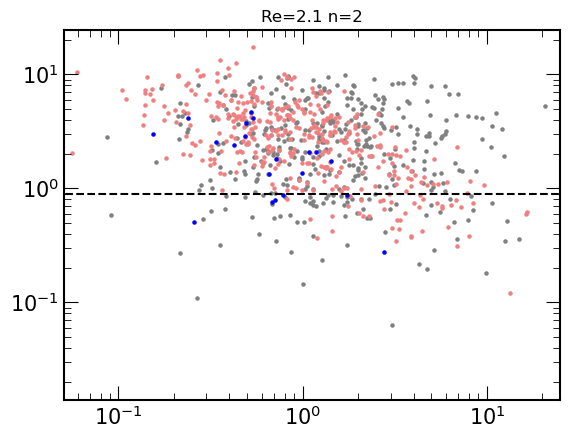

In [6]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 2.0363292694091797
finished until t = 0.5 19.549840688705444
finished until t = 1.0 51.06529664993286


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 1.5 94.5742928981781
finished until t = 2.0 148.84272146224976
finished until t = 2.5 214.14377212524414
finished until t = 3.0 292.8753960132599
finished until t = 3.5 395.87152338027954
finished until t = 4.0 517.5321133136749
finished until t = 4.5 655.5596497058868
finished until t = 5.0 825.1217725276947
finished until t = 5.5 1009.6189231872559
finished until t = 6.0 1205.0697917938232
finished until t = 6.5 1413.3309564590454
finished until t = 7.0 1633.820229768753
finished until t = 7.5 1866.1352181434631
finished until t = 8.0 2106.0678346157074
finished until t = 8.5 2357.919298171997
finished until t = 9.0 2619.123054265976
finished until t = 9.5 2888.464821100235
finished until t = 10.0 3169.9476141929626


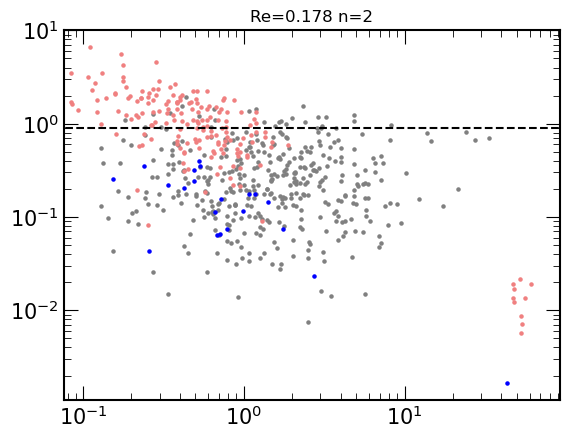

finished until t = 0.0 2.2765326499938965
finished until t = 0.5 34.37376046180725
finished until t = 1.0 93.70339894294739
finished until t = 1.5 178.68162751197815
finished until t = 2.0 280.80561447143555
finished until t = 2.5 398.1637673377991
finished until t = 3.0 534.7484197616577
finished until t = 3.5 688.6040005683899
finished until t = 4.0 860.3783752918243
finished until t = 4.5 1047.553768157959
finished until t = 5.0 1252.6078660488129
finished until t = 5.5 1473.4857907295227
finished until t = 6.0 1708.8107426166534
finished until t = 6.5 1947.9195804595947
finished until t = 7.0 2187.0738570690155
finished until t = 7.5 2413.6518745422363
finished until t = 8.0 2619.5004284381866
finished until t = 8.5 2829.5264790058136
finished until t = 9.0 3046.6888897418976
finished until t = 9.5 3272.92729640007
finished until t = 10.0 3501.0531742572784


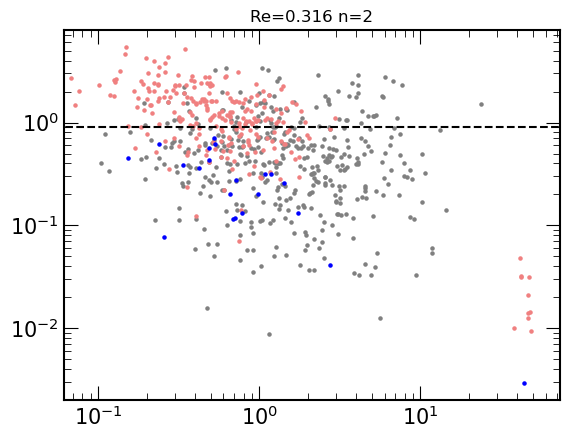

In [7]:
#NFW

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        

